In [1]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import preprocessing

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

smart_card_data = pd.read_csv('./data/smart_card_data.csv')
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0)
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0)
bus_sttn = pd.read_csv('./data/bus_sttn.csv')
route_curve = pd.read_csv('./data/route_curve.csv', encoding = 'cp949')

### getrouteinfoall
getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']] 

### bus_sttn
bus_sttn_df = bus_sttn[['bus_sttn_id', 'posx', 'posy']]

In [2]:
from preprocessing import data_preprocessing

smart_card_data = data_preprocessing.smart_card_preprocessing(smart_card_data)
smart_card_data.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,WEEKDAY,DAY
0,541463722,680,0,30300052,1,8002432,8001526,1,1250,0,2022-04-01 08:17:06,2022-04-01 08:30:41,4,1
1,540104832,675,0,30300083,1,8001279,8001538,1,1250,0,2022-04-01 09:25:42,2022-04-01 09:37:29,4,1
2,608695670,673,1,30300003,1,8001777,8007023,1,0,0,2022-04-01 19:12:53,2022-04-01 19:21:42,4,1


# 요일별

In [4]:
smart_card_data_monday = smart_card_data[smart_card_data['WEEKDAY']==0]
smart_card_data_tuesday = smart_card_data[smart_card_data['WEEKDAY']==1]
smart_card_data_wednesday = smart_card_data[smart_card_data['WEEKDAY']==2]
smart_card_data_thursday = smart_card_data[smart_card_data['WEEKDAY']==3]
smart_card_data_friday = smart_card_data[smart_card_data['WEEKDAY']==4]

In [6]:
def day_preprocessing(exdata):
    exdata.drop(labels = ['WEEKDAY','DAY'], axis = 1, inplace = True)
    exdata['GETON_HOUR'] = exdata['GETON_DATETIME'].dt.hour
    return exdata

In [7]:
smart_card_data_monday = day_preprocessing(smart_card_data_monday)
smart_card_data_tuesday = day_preprocessing(smart_card_data_tuesday)
smart_card_data_wednesday = day_preprocessing(smart_card_data_wednesday)
smart_card_data_thursday = day_preprocessing(smart_card_data_thursday)
smart_card_data_friday = day_preprocessing(smart_card_data_friday)

-----

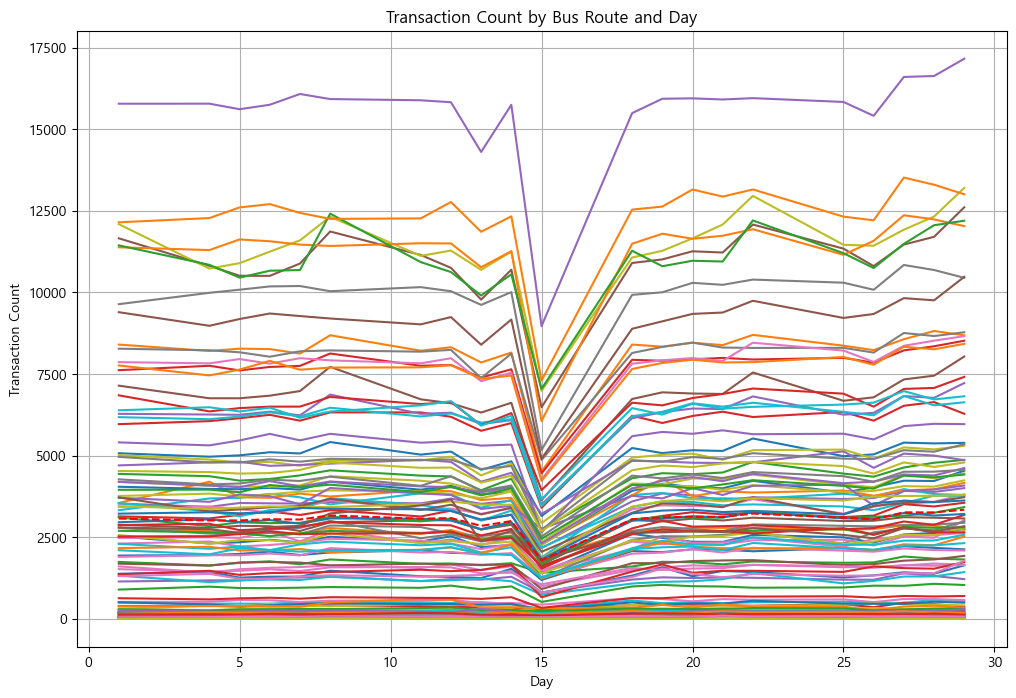

In [3]:
# BUS_ROUTE_ID와 DAY를 기준으로 데이터를 그룹화하고 각 그룹의 행 수를 계산
grouped_data = smart_card_data.groupby(['BUS_ROUTE_ID', 'DAY']).size().reset_index(name='COUNT')

# 각 날짜별로 모든 버스 노선에 대한 평균 거래 수를 계산
daily_average = grouped_data.groupby('DAY')['COUNT'].mean().reset_index(name='DAILY_AVERAGE')

# 각 날짜별로 평균 거래 수에 가장 가까운 거래 수를 가진 날짜를 찾음
closest_dates = []
for _, row in daily_average.iterrows():
    day = row['DAY']
    average_count = row['DAILY_AVERAGE']
    closest_date = grouped_data.loc[grouped_data['DAY'] == day, 'COUNT'].\
                   apply(lambda x: abs(x - average_count)).idxmin()
    closest_dates.append(grouped_data.loc[closest_date, 'BUS_ROUTE_ID'])

# 각 버스 노선별로 그래프를 그리는 함수를 생성
def plot_route_graph(route_id):
    route_data = grouped_data[grouped_data['BUS_ROUTE_ID'] == route_id]
    plt.plot(route_data['DAY'], route_data['COUNT'], label=f'Route {route_id}')

# 유일한 BUS_ROUTE_ID 값을 가져옴
unique_route_ids = smart_card_data['BUS_ROUTE_ID'].unique()

plt.figure(figsize=(12, 8))
for route_id in unique_route_ids:
    plot_route_graph(route_id)

# 각 날짜별로 모든 버스 노선에 대한 평균 거래 수를 나타내는 선을 추가
plt.plot(daily_average['DAY'], daily_average['DAILY_AVERAGE'], color='r', linestyle='--', label='Daily Average')

plt.xlabel('Day')
plt.ylabel('Transaction Count')
plt.title('Transaction Count by Bus Route and Day')
plt.grid(True)
plt.show()

In [54]:
daily_average = daily_average[daily_average['DAY']!=15] # 15일의 DAILY_AVERAGE는 이상치라 판단하여 제거해줌
daily_average['AVERAGE'] = daily_average['DAILY_AVERAGE'].mean() # 일별 평균의 평균을 구해줌
daily_average['DIFFERENCE'] = abs(daily_average['DAILY_AVERAGE'] - daily_average['AVERAGE']) # 일별 평균의 평균과 일별 평균의 차이를 구함
daily_average.sort_values('DIFFERENCE',ascending = True).head(5) # 차이가 가장 적은 날짜 : 4월 25일

,DAY,DAILY_AVERAGE,AVERAGE,DIFFERENCE
16,25,3098.238532,3100.855505,2.616972
12,19,3109.183486,3100.855505,8.327982
7,12,3087.541284,3100.855505,13.314220
14,21,3120.908257,3100.855505,20.052752
13,20,3128.559633,3100.855505,27.704128


# 4월 25일 데이터

In [6]:
df_0425 = smart_card_data[smart_card_data['DAY']==25]
df_0425.drop(labels = ['WEEKDAY','DAY'],axis = 1, inplace = True)
df_0425['GETON_HOUR'] = df_0425['GETON_DATETIME'].dt.hour
df_0425.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
169539,734471053,675,0,30300059,1,8006006,8001930,1,1250,0,2022-04-25 19:19:47,2022-04-25 19:38:02,19
169540,661607970,676,0,30300070,1,8002794,8002155,1,1250,0,2022-04-25 07:53:58,2022-04-25 08:16:20,7
169541,706749254,675,0,30300079,1,8001721,8002802,1,1250,0,2022-04-25 08:07:51,2022-04-25 08:39:44,8


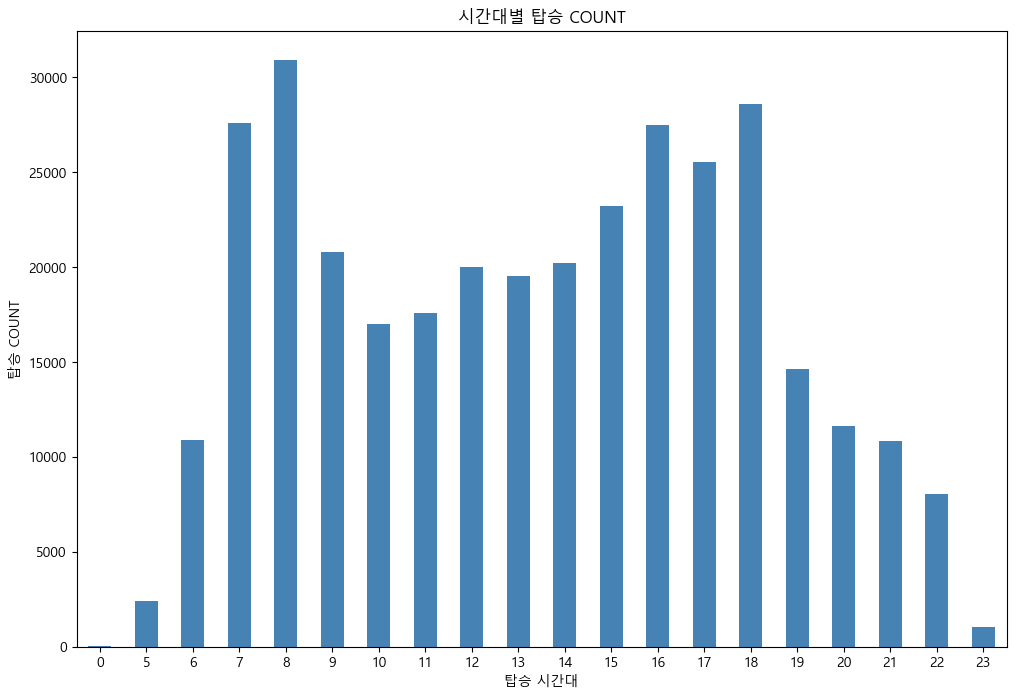

In [7]:
# GETON_HOUR을 기준으로 그룹화하여 해당 시간대별 이용자 수를 계산
hourly_usage = df_0425.groupby('GETON_HOUR')['CARD_NO'].count()

plt.figure(figsize=(12, 8))
hourly_usage.plot(kind='bar',  color = 'steelblue')
plt.xlabel('탑승 시간대')
plt.ylabel('탑승 COUNT')
plt.xticks(rotation=0)
plt.title('시간대별 탑승 COUNT')
plt.show()

## 출근 시간대 (7시, 8시, 9시)

In [8]:
from preprocessing import transf_data_preprocessing

df_0425_go_to = transf_data_preprocessing.filtering_time(df_0425, 7, 8, 9)
df_0425_go_to.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
169540,661607970,676,0,30300070,1,8002794,8002155,1,1250,0,2022-04-25 07:53:58,2022-04-25 08:16:20,7
169541,706749254,675,0,30300079,1,8001721,8002802,1,1250,0,2022-04-25 08:07:51,2022-04-25 08:39:44,8
169545,771903902,676,0,30300037,1,8001590,8002997,1,1250,0,2022-04-25 08:37:12,2022-04-25 08:42:02,8


### 환승횟수 2회

In [9]:
transf_is_2_morning, transf_is_not_2_morning = transf_data_preprocessing.transf_2_preprocessing(df_0425_go_to)
transf_is_2_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
82,91472025,676,0,30300043,1,8001358,8001628,1,1250,0,2022-04-25 08:18:09,2022-04-25 09:04:33,8
83,91472025,675,1,30300095,1,8002935,8001250,1,0,0,2022-04-25 09:47:15,2022-04-25 09:52:46,9
84,91472025,675,2,30300067,1,8001250,8002635,1,0,0,2022-04-25 09:53:23,2022-04-25 10:11:20,9


In [20]:
transf_is_2_morning_merge = transf_data_preprocessing.transf_2_merge(transf_is_2_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_2_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,91472025,676,108,0,8001358,1250,2022-04-25 08:18:09,36.287640,127.464714,8001628,0,2022-04-25 09:04:33,36.349995,127.390335,675,916,8002935,0,2022-04-25 09:47:15,36.354670,127.394875,8001250,0,2022-04-25 09:52:46,36.347336,127.401566,675,514,8001250,0,2022-04-25 09:53:23,8002635,0,2022-04-25 10:11:20,36.329105,127.43359
1,131074379,675,115,0,8005992,1250,2022-04-25 07:35:44,36.337740,127.338036,8002547,0,2022-04-25 07:56:20,36.307274,127.363945,676,201,8002547,0,2022-04-25 07:58:35,36.307274,127.363945,8002437,0,2022-04-25 08:28:33,36.329100,127.427444,675,511,8002437,0,2022-04-25 08:32:11,8002635,0,2022-04-25 08:34:53,36.329105,127.43359
2,302620769,676,605,0,8002486,1250,2022-04-25 08:10:00,36.335636,127.449290,8001412,0,2022-04-25 08:19:14,36.329525,127.433680,676,103,8002358,0,2022-04-25 08:26:50,36.328297,127.434410,8002734,0,2022-04-25 08:38:36,36.322990,127.414650,675,311,8002733,0,2022-04-25 09:01:22,8002635,0,2022-04-25 09:11:19,36.329105,127.43359


In [11]:
# 'GETOFF_BUS_STTN_ID_3' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = transf_is_2_morning_merge['GETOFF_BUS_STTN_ID_3'].value_counts().head(5).index

# DataFrame을 'GETOFF_BUS_STTN_ID_3' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_2_morning_merge[transf_is_2_morning_merge['GETOFF_BUS_STTN_ID_3'].isin(top_5_bus_sttn_ids)]

map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=12)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETOFF_BUS_X_3']
    lon = row['GETOFF_BUS_Y_3']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [12]:
# mymap

### 환승횟수 1회

In [13]:
transf_is_1_morning, transf_is_not_1_morning = transf_data_preprocessing.transf_1_preprocessing(df_0425_go_to)
transf_is_1_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
10466,90027797,676,0,30300131,1,8001079,8002814,1,1250,0,2022-04-25 07:09:00,2022-04-25 07:36:16,7
10467,90027797,676,1,30300089,1,8002814,8002537,1,0,0,2022-04-25 07:43:02,2022-04-25 08:08:28,7
5142,90053324,676,0,30300041,1,8005990,8002720,1,1250,0,2022-04-25 09:05:20,2022-04-25 09:12:39,9


In [17]:
transf_is_1_morning_merge = transf_data_preprocessing.transf_1_merge(transf_is_1_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_1_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,90027797,676,203,0,8001079,1250,2022-04-25 07:09:00,36.30686,127.340850,8002814,0,2022-04-25 07:36:16,36.35306,127.379524,676,705,8002814,0,2022-04-25 07:43:02,36.35306,127.379524,8002537,0,2022-04-25 08:08:28,36.40083,127.40498
1,712034502,675,318,0,8001949,1250,2022-04-25 07:02:43,36.34238,127.387480,8002814,0,2022-04-25 07:07:13,36.35306,127.379524,676,705,8002814,0,2022-04-25 07:09:32,36.35306,127.379524,8002537,0,2022-04-25 07:28:37,36.40083,127.40498
2,645114698,675,211,0,8001491,1250,2022-04-25 09:03:16,36.31539,127.379196,8002814,0,2022-04-25 09:27:35,36.35306,127.379524,676,705,8002814,0,2022-04-25 09:38:16,36.35306,127.379524,8002537,0,2022-04-25 09:58:39,36.40083,127.40498


In [21]:
# 'GETOFF_BUS_STTN_ID_2' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_1_morning_merge['GETOFF_BUS_STTN_ID_2'].value_counts().head(10).index

# DataFrame을 'GETOFF_BUS_STTN_ID_2' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_1_morning_merge[transf_is_1_morning_merge['GETOFF_BUS_STTN_ID_2'].isin(top_10_bus_sttn_ids)]

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
25,763255887,676,203,0,8001079,1250,2022-04-25 07:52:26,36.30686,127.34085,8002814,0,2022-04-25 08:27:46,36.35306,127.379524,676,604,8002814,0,2022-04-25 08:35:45,36.35306,127.379524,8001923,0,2022-04-25 08:42:36,36.36857,127.37971
26,1110323135,676,203,0,8007396,1250,2022-04-25 08:59:28,36.29205,127.33374,8002814,0,2022-04-25 09:37:22,36.35306,127.379524,676,705,8002814,0,2022-04-25 09:38:21,36.35306,127.379524,8001923,0,2022-04-25 09:45:17,36.36857,127.37971
27,766314601,676,203,0,8007283,1250,2022-04-25 08:42:18,36.29396,127.34372,8002814,0,2022-04-25 09:24:14,36.35306,127.379524,675,318,8002814,0,2022-04-25 09:26:55,36.35306,127.379524,8001923,0,2022-04-25 09:34:13,36.36857,127.37971


In [22]:
map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=13)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETOFF_BUS_X_2']
    lon = row['GETOFF_BUS_Y_2']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [24]:
# mymap

### 환승횟수 0회

In [25]:
transf_is_0_morning, transf_is_not_0_morning = transf_data_preprocessing.transf_0_preprocessing(df_0425_go_to)
transf_is_0_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
169541,706749254,675,0,30300079,1,8001721,8002802,1,1250,0,2022-04-25 08:07:51,2022-04-25 08:39:44,8
169545,771903902,676,0,30300037,1,8001590,8002997,1,1250,0,2022-04-25 08:37:12,2022-04-25 08:42:02,8
169556,689982392,676,0,30300041,1,8002997,8001076,1,1250,0,2022-04-25 08:29:44,2022-04-25 08:47:57,8


In [26]:
transf_is_0_morning_merge = transf_data_preprocessing.transf_0_merge(transf_is_0_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_0_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,706749254,675,615,0,8001721,1250,2022-04-25 08:07:51,36.366577,127.429886,8002802,0,2022-04-25 08:39:44,36.320297,127.42004
1,741298317,675,615,0,8001721,1250,2022-04-25 08:07:54,36.366577,127.429886,8002802,0,2022-04-25 08:40:07,36.320297,127.42004
2,746140476,675,615,0,8001721,1250,2022-04-25 08:07:53,36.366577,127.429886,8002802,0,2022-04-25 08:39:48,36.320297,127.42004


In [30]:
# 'GETOFF_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 20개의 값
top_20_bus_sttn_ids = transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].value_counts().head(20).index

# DataFrame을 'GETOFF_BUS_STTN_ID' 열의 값이 상위 20개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_0_morning_merge[transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].isin(top_20_bus_sttn_ids)]

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
1078,762889777,676,706,0,8001721,1250,2022-04-25 09:22:14,36.366577,127.429886,8002453,0,2022-04-25 09:54:38,36.3506,127.37813
1079,903672203,676,703,0,8002541,1250,2022-04-25 07:50:19,36.301750,127.366470,8002453,0,2022-04-25 08:33:10,36.3506,127.37813
1080,544635159,676,703,0,8002541,1250,2022-04-25 08:00:56,36.301750,127.366470,8002453,0,2022-04-25 08:45:52,36.3506,127.37813
1081,725257543,676,703,0,8002541,1250,2022-04-25 08:00:25,36.301750,127.366470,8002453,0,2022-04-25 08:45:30,36.3506,127.37813
1082,541744703,676,703,0,8002541,1250,2022-04-25 09:04:26,36.301750,127.366470,8002453,0,2022-04-25 09:40:24,36.3506,127.37813


In [28]:
# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETOFF_BUS_X']
    lon = row['GETOFF_BUS_Y']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [31]:
# mymap

## 퇴근 시간대 (16시, 17시, 18시)

In [32]:
from preprocessing import transf_data_preprocessing

df_0425_leave_to = transf_data_preprocessing.filtering_time(df_0425, 16, 17, 18)
df_0425_leave_to.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
169542,773407290,675,0,30300081,1,8002088,8003006,1,1250,0,2022-04-25 18:49:38,2022-04-25 18:59:58,18
169543,776506384,674,0,30300002,1,8001418,8002132,1,1250,0,2022-04-25 18:44:47,2022-04-25 19:24:29,18
169544,745621784,676,0,30300073,1,8001576,8002148,1,1250,0,2022-04-25 18:17:49,2022-04-25 18:52:06,18


### 환승횟수 2회

In [34]:
transf_is_2_night, transf_is_not_2_night = transf_data_preprocessing.transf_2_preprocessing(df_0425_leave_to)
transf_is_2_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
1740,93547495,674,0,30300002,1,8001096,8005994,1,1250,0,2022-04-25 16:14:43,2022-04-25 16:26:08,16
1741,93547495,675,1,30300079,1,8002631,8001539,1,0,0,2022-04-25 16:36:27,2022-04-25 16:51:10,16
1742,93547495,680,2,30300013,1,8001539,8002600,1,0,0,2022-04-25 16:51:21,2022-04-25 16:54:52,16


In [35]:
transf_is_2_night_merge = transf_data_preprocessing.transf_2_merge(transf_is_2_night, getrouteinfoall_df, bus_sttn_df)
transf_is_2_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,93547495,674,2,0,8001096,1250,2022-04-25 16:14:43,36.349014,127.43566,8005994,0,2022-04-25 16:26:08,36.329630,127.427960,675,615,8002631,0,2022-04-25 16:36:27,36.328403,127.424774,8001539,0,2022-04-25 16:51:10,36.31461,127.40472,680,30,8001539,0,2022-04-25 16:51:21,8002600,0,2022-04-25 16:54:52,36.308456,127.39575
1,176327873,675,616,0,8001983,1250,2022-04-25 17:43:08,36.366470,127.44497,8002309,0,2022-04-25 17:58:02,36.346275,127.432490,675,615,8002309,0,2022-04-25 17:59:27,36.346275,127.432490,8001539,0,2022-04-25 18:25:23,36.31461,127.40472,675,313,8001539,0,2022-04-25 18:29:23,8002600,0,2022-04-25 18:32:52,36.308456,127.39575
2,726039019,675,315,0,8002601,1250,2022-04-25 16:31:45,36.308167,127.39578,8002719,0,2022-04-25 16:34:21,36.312460,127.402214,675,311,8001538,0,2022-04-25 16:41:48,36.314426,127.404930,8002627,0,2022-04-25 17:00:22,36.32884,127.42673,675,313,8002358,0,2022-04-25 17:38:13,8002600,0,2022-04-25 18:08:19,36.308456,127.39575


In [36]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = transf_is_2_night_merge['GETON_BUS_STTN_ID_1'].value_counts().head(5).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_2_night_merge[transf_is_2_night_merge['GETON_BUS_STTN_ID_1'].isin(top_5_bus_sttn_ids)]

In [37]:
mymap = folium.Map(location=map_center, zoom_start=12)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETON_BUS_X_1']
    lon = row['GETON_BUS_Y_1']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [39]:
# mymap

### 환승횟수 1회

In [40]:
transf_is_1_night, transf_is_not_1_night = transf_data_preprocessing.transf_1_preprocessing(df_0425_leave_to)
transf_is_1_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
5050,87595336,832,0,30300128,1,8007290,8007280,1,1700,0,2022-04-25 16:27:54,2022-04-25 16:37:59,16
5051,87595336,676,1,30300040,1,8007280,8001097,1,0,0,2022-04-25 16:45:06,2022-04-25 17:05:02,16
17970,90069328,676,0,30300037,1,8002920,8002412,1,1250,0,2022-04-25 16:05:53,2022-04-25 16:20:25,16


In [41]:
transf_is_1_night_merge = transf_data_preprocessing.transf_1_merge(transf_is_1_night, getrouteinfoall_df, bus_sttn_df)
transf_is_1_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,87595336,832,B1,0,8007290,1700,2022-04-25 16:27:54,36.43803,127.395670,8007280,0,2022-04-25 16:37:59,36.35561,127.40646,676,105,8007280,0,2022-04-25 16:45:06,36.35561,127.40646,8001097,0,2022-04-25 17:05:02,36.34904,127.43719
1,540616330,832,B1,0,8007292,1700,2022-04-25 17:14:59,36.48127,127.307530,8007280,300,2022-04-25 17:41:41,36.35561,127.40646,676,105,8007280,0,2022-04-25 17:48:57,36.35561,127.40646,8001097,0,2022-04-25 18:06:15,36.34904,127.43719
2,537245924,832,B1,0,8007080,1700,2022-04-25 17:06:17,36.50499,127.261505,8007280,300,2022-04-25 17:49:34,36.35561,127.40646,676,105,8007280,0,2022-04-25 17:57:01,36.35561,127.40646,8001097,0,2022-04-25 18:13:42,36.34904,127.43719


In [43]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_1_night_merge['GETON_BUS_STTN_ID_1'].value_counts().head(10).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_1_night_merge[transf_is_1_night_merge['GETON_BUS_STTN_ID_1'].isin(top_10_bus_sttn_ids)]

In [44]:
mymap = folium.Map(location=map_center, zoom_start=13)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETON_BUS_X_1']
    lon = row['GETON_BUS_Y_1']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [46]:
# mymap

### 환승횟수 0회

In [47]:
transf_is_0_night, transf_is_not_0_night = transf_data_preprocessing.transf_0_preprocessing(df_0425_leave_to)
transf_is_0_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
169542,773407290,675,0,30300081,1,8002088,8003006,1,1250,0,2022-04-25 18:49:38,2022-04-25 18:59:58,18
169543,776506384,674,0,30300002,1,8001418,8002132,1,1250,0,2022-04-25 18:44:47,2022-04-25 19:24:29,18
169544,745621784,676,0,30300073,1,8001576,8002148,1,1250,0,2022-04-25 18:17:49,2022-04-25 18:52:06,18


In [48]:
transf_is_0_night_merge = transf_data_preprocessing.transf_0_merge(transf_is_0_night, getrouteinfoall_df, bus_sttn_df)
transf_is_0_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,773407290,675,617,0,8002088,1250,2022-04-25 18:49:38,36.35114,127.38867,8003006,0,2022-04-25 18:59:58,36.35812,127.4125
1,702009703,675,617,0,8002088,1250,2022-04-25 18:49:41,36.35114,127.38867,8003006,0,2022-04-25 18:59:56,36.35812,127.4125
2,759954796,676,703,0,8002088,1250,2022-04-25 17:02:33,36.35114,127.38867,8003006,0,2022-04-25 17:16:09,36.35812,127.4125


In [49]:
# 'GETON_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 20개의 값
top_20_bus_sttn_ids = transf_is_0_night_merge['GETON_BUS_STTN_ID'].value_counts().head(20).index

# DataFrame을 'GETON_BUS_STTN_ID' 열의 값이 상위 20개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_0_night_merge[transf_is_0_night_merge['GETON_BUS_STTN_ID'].isin(top_20_bus_sttn_ids)]

In [50]:
# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETON_BUS_X']
    lon = row['GETON_BUS_Y']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [52]:
# mymap

# 4월 8일 데이터

In [57]:
df_0408 = smart_card_data[smart_card_data['DAY']==8]
df_0408.drop(labels = ['WEEKDAY','DAY'],axis = 1, inplace = True)
df_0408['GETON_HOUR'] = df_0408['GETON_DATETIME'].dt.hour
df_0408.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2203363,274401654,676,3,30300041,1,8001097,8001401,1,0,0,2022-04-08 11:50:12,2022-04-08 11:56:44,11
2203364,749014275,674,0,30300002,1,8001963,8001097,1,1250,0,2022-04-08 16:37:42,2022-04-08 17:02:36,16
2203365,753512336,674,0,30300100,1,8001028,8001916,1,1250,0,2022-04-08 12:06:40,2022-04-08 12:13:38,12


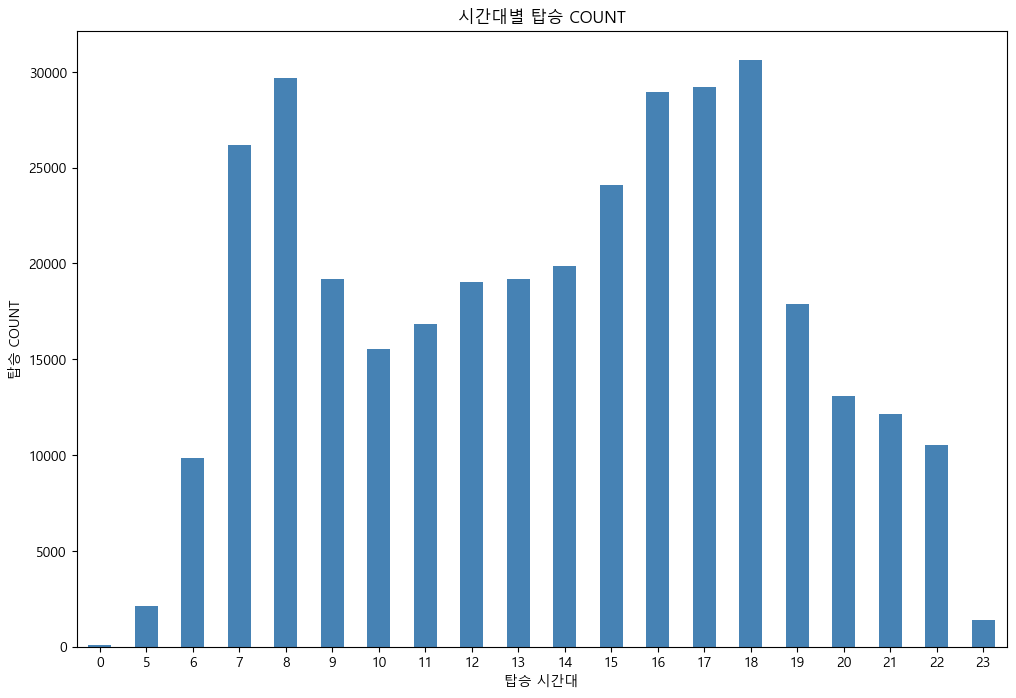

In [58]:
# GETON_HOUR을 기준으로 그룹화하여 해당 시간대별 이용자 수를 계산
hourly_usage = df_0408.groupby('GETON_HOUR')['CARD_NO'].count()

plt.figure(figsize=(12, 8))
hourly_usage.plot(kind='bar',  color = 'steelblue')
plt.xlabel('탑승 시간대')
plt.ylabel('탑승 COUNT')
plt.xticks(rotation=0)
plt.title('시간대별 탑승 COUNT')
plt.show()

## 출근 시간대 (7시, 8시, 9시)

In [59]:
from preprocessing import transf_data_preprocessing

df_0408_go_to = transf_data_preprocessing.filtering_time(df_0408, 7, 8, 9)
df_0408_go_to.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2203366,770042931,675,0,30300046,1,8002376,8001526,1,1250,0,2022-04-08 07:56:55,2022-04-08 08:36:21,7
2203368,649638418,675,0,30300081,1,8002217,8002969,1,1250,0,2022-04-08 07:33:14,2022-04-08 07:49:08,7
2203370,171762203,676,2,30300040,1,8001005,8002241,1,0,0,2022-04-08 08:56:07,2022-04-08 09:04:54,8


### 환승횟수 2회

In [60]:
transf_is_2_morning, transf_is_not_2_morning = transf_data_preprocessing.transf_2_preprocessing(df_0408_go_to)
transf_is_2_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2518,90027797,676,0,30300131,1,8001079,8002814,1,1250,0,2022-04-08 07:08:42,2022-04-08 07:29:12,7
2519,90027797,676,1,30300054,1,8002814,8001923,1,0,0,2022-04-08 07:30:37,2022-04-08 07:37:25,7
2520,90027797,675,2,30300096,1,8001923,8002026,1,0,0,2022-04-08 07:42:53,2022-04-08 08:00:57,7


In [61]:
transf_is_2_morning_merge = transf_data_preprocessing.transf_2_merge(transf_is_2_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_2_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,90027797,676,203,0,8001079,1250,2022-04-08 07:08:42,36.30686,127.34085,8002814,0,2022-04-08 07:29:12,36.35306,127.379524,676,301,8002814,0,2022-04-08 07:30:37,36.35306,127.379524,8001923,0,2022-04-08 07:37:25,36.36857,127.37971,675,918,8001923,0,2022-04-08 07:42:53,8002026,0,2022-04-08 08:00:57,36.39971,127.40374
1,699274576,676,203,0,8001089,1250,2022-04-08 08:01:16,36.34730,127.37599,8002453,0,2022-04-08 08:01:39,36.35060,127.378130,676,705,8002814,0,2022-04-08 08:07:17,36.35306,127.379524,8001923,0,2022-04-08 08:11:22,36.36857,127.37971,675,911,8001923,0,2022-04-08 08:16:16,8005563,0,2022-04-08 08:20:23,36.37714,127.39360
2,742105801,676,703,0,8002966,1250,2022-04-08 07:55:37,36.32258,127.37826,8002453,0,2022-04-08 08:14:09,36.35060,127.378130,676,301,8002453,0,2022-04-08 08:17:53,36.35060,127.378130,8001923,0,2022-04-08 08:25:47,36.36857,127.37971,675,911,8001923,0,2022-04-08 08:38:59,8005563,0,2022-04-08 08:45:27,36.37714,127.39360


In [62]:
# 'GETOFF_BUS_STTN_ID_3' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = transf_is_2_morning_merge['GETOFF_BUS_STTN_ID_3'].value_counts().head(5).index

# DataFrame을 'GETOFF_BUS_STTN_ID_3' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_2_morning_merge[transf_is_2_morning_merge['GETOFF_BUS_STTN_ID_3'].isin(top_5_bus_sttn_ids)]

map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=12)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETOFF_BUS_X_3']
    lon = row['GETOFF_BUS_Y_3']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

### 환승횟수 1회

In [68]:
transf_is_1_morning, transf_is_not_1_morning = transf_data_preprocessing.transf_1_preprocessing(df_0408_go_to)
transf_is_1_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
15989,88299523,676,0,30300088,1,8002963,8001196,1,1250,0,2022-04-08 09:28:49,2022-04-08 09:37:10,9
15990,88299523,675,1,30300049,1,8001282,8002407,1,0,0,2022-04-08 09:45:16,2022-04-08 09:47:49,9
4399,90052852,676,0,30300073,1,8001997,8001005,1,1250,0,2022-04-08 07:47:52,2022-04-08 08:16:25,7


In [69]:
transf_is_1_morning_merge = transf_data_preprocessing.transf_1_merge(transf_is_1_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_1_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,88299523,676,704,0,8002963,1250,2022-04-08 09:28:49,36.385365,127.352980,8001196,0,2022-04-08 09:37:10,36.36625,127.33871,675,119,8001282,0,2022-04-08 09:45:16,36.36545,127.335724,8002407,0,2022-04-08 09:47:49,36.3777,127.32474
1,694840575,676,106,0,8002850,1250,2022-04-08 07:04:26,36.359947,127.366585,8002721,0,2022-04-08 07:11:53,36.36156,127.34411,675,119,8002722,0,2022-04-08 07:20:24,36.36265,127.343680,8002407,0,2022-04-08 07:28:31,36.3777,127.32474
2,725673919,676,105,0,8001193,1250,2022-04-08 09:26:00,36.360800,127.349540,8002721,0,2022-04-08 09:28:08,36.36156,127.34411,676,101,8002722,0,2022-04-08 09:47:36,36.36265,127.343680,8002407,0,2022-04-08 09:59:46,36.3777,127.32474


In [70]:
# 'GETOFF_BUS_STTN_ID_2' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_1_morning_merge['GETOFF_BUS_STTN_ID_2'].value_counts().head(10).index

# DataFrame을 'GETOFF_BUS_STTN_ID_2' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_1_morning_merge[transf_is_1_morning_merge['GETOFF_BUS_STTN_ID_2'].isin(top_10_bus_sttn_ids)]

### 환승횟수 0회

In [73]:
transf_is_0_morning, transf_is_not_0_morning = transf_data_preprocessing.transf_0_preprocessing(df_0408_go_to)
transf_is_0_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2203366,770042931,675,0,30300046,1,8002376,8001526,1,1250,0,2022-04-08 07:56:55,2022-04-08 08:36:21,7
2203368,649638418,675,0,30300081,1,8002217,8002969,1,1250,0,2022-04-08 07:33:14,2022-04-08 07:49:08,7
2203606,510986912,675,0,30300055,4,8001444,8002488,1,750,0,2022-04-08 07:17:17,2022-04-08 07:23:36,7


In [74]:
transf_is_0_morning_merge = transf_data_preprocessing.transf_0_merge(transf_is_0_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_0_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,770042931,675,114,0,8002376,1250,2022-04-08 07:56:55,36.368850,127.317825,8001526,0,2022-04-08 08:36:21,36.30373,127.34588
1,677917881,675,114,3,8002411,0,2022-04-08 09:26:54,36.354877,127.341520,8001526,0,2022-04-08 09:51:06,36.30373,127.34588
2,698212381,675,114,2,8002411,0,2022-04-08 09:07:57,36.354877,127.341520,8001526,0,2022-04-08 09:31:45,36.30373,127.34588


In [75]:
# 'GETOFF_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 20개의 값
top_20_bus_sttn_ids = transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].value_counts().head(20).index

# DataFrame을 'GETOFF_BUS_STTN_ID' 열의 값이 상위 20개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_0_morning_merge[transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].isin(top_20_bus_sttn_ids)]

## 퇴근 시간대 (16시, 17시, 18시)

In [79]:
from preprocessing import transf_data_preprocessing

df_0408_leave_to = transf_data_preprocessing.filtering_time(df_0408, 16, 17, 18)
df_0408_leave_to.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2203364,749014275,674,0,30300002,1,8001963,8001097,1,1250,0,2022-04-08 16:37:42,2022-04-08 17:02:36,16
2203369,535466965,678,1,30300074,1,8001876,8002480,1,0,0,2022-04-08 18:46:39,2022-04-08 18:56:59,18
2203372,110474117,676,1,30300054,1,8002468,8001368,1,0,0,2022-04-08 16:03:52,2022-04-08 16:16:20,16


### 환승횟수 2회

In [80]:
transf_is_2_night, transf_is_not_2_night = transf_data_preprocessing.transf_2_preprocessing(df_0408_leave_to)
transf_is_2_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
4039,90069478,675,0,30300083,1,8001669,8001491,1,1250,0,2022-04-08 17:57:25,2022-04-08 18:07:26,17
4040,90069478,676,1,30300051,1,8001493,8002119,1,0,0,2022-04-08 18:25:41,2022-04-08 18:27:13,18
4041,90069478,676,2,30300087,1,8002119,8007444,1,0,0,2022-04-08 18:30:29,2022-04-08 18:38:59,18


In [81]:
transf_is_2_night_merge = transf_data_preprocessing.transf_2_merge(transf_is_2_night, getrouteinfoall_df, bus_sttn_df)
transf_is_2_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,171755894,676,201,0,8001935,1250,2022-04-08 17:10:45,36.321037,127.406900,8001493,0,2022-04-08 17:15:58,36.314804,127.383514,680,42,8001493,0,2022-04-08 17:22:44,36.314804,127.383514,8002119,0,2022-04-08 17:27:52,36.3117,127.37664,676,703,8002119,0,2022-04-08 17:31:37,8001198,0,2022-04-08 17:37:07,36.306957,127.36462
1,486884592,676,703,0,8001735,1250,2022-04-08 16:14:12,36.328190,127.380714,8001279,0,2022-04-08 16:18:21,36.317562,127.378060,675,211,8001494,0,2022-04-08 16:50:51,36.314710,127.379150,8002119,0,2022-04-08 16:51:47,36.3117,127.37664,680,46,8002119,0,2022-04-08 17:09:56,8001696,0,2022-04-08 17:40:21,36.273518,127.26867
2,534223329,675,615,0,8002724,750,2022-04-08 16:15:44,36.317920,127.413890,8002119,0,2022-04-08 16:29:12,36.311700,127.376640,680,22,8001490,0,2022-04-08 16:47:06,36.313805,127.381260,8002119,0,2022-04-08 16:48:10,36.3117,127.37664,676,201,8002119,0,2022-04-08 16:53:17,8001290,0,2022-04-08 17:10:04,36.298435,127.34066


In [82]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = transf_is_2_night_merge['GETON_BUS_STTN_ID_1'].value_counts().head(5).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_2_night_merge[transf_is_2_night_merge['GETON_BUS_STTN_ID_1'].isin(top_5_bus_sttn_ids)]

### 환승횟수 1회

In [85]:
transf_is_1_night, transf_is_not_1_night = transf_data_preprocessing.transf_1_preprocessing(df_0408_leave_to)
transf_is_1_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
5207,90052852,676,0,30300037,1,8002658,8002075,1,1250,0,2022-04-08 17:20:57,2022-04-08 17:27:13,17
5208,90052852,676,1,30300073,1,8002075,8002963,1,0,0,2022-04-08 17:53:49,2022-04-08 18:18:56,17
17696,90067900,676,0,30300070,1,8002729,8001421,1,1250,0,2022-04-08 17:12:23,2022-04-08 17:21:04,17


In [86]:
transf_is_1_night_merge = transf_data_preprocessing.transf_1_merge(transf_is_1_night, getrouteinfoall_df, bus_sttn_df)
transf_is_1_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,90052852,676,102,0,8002658,1250,2022-04-08 17:20:57,36.35911,127.424904,8002075,0,2022-04-08 17:27:13,36.357666,127.39748,676,606,8002075,0,2022-04-08 17:53:49,36.357666,127.39748,8002963,0,2022-04-08 18:18:56,36.385365,127.35298
1,742545242,676,705,0,8007101,1250,2022-04-08 16:08:08,36.38496,127.405110,8001922,0,2022-04-08 16:19:37,36.368270,127.37935,676,606,8001923,0,2022-04-08 16:26:23,36.368570,127.37971,8002963,0,2022-04-08 16:40:27,36.385365,127.35298
2,298525895,676,301,0,8002453,1250,2022-04-08 18:17:10,36.35060,127.378130,8002556,0,2022-04-08 18:26:44,36.361683,127.37961,676,606,8001923,0,2022-04-08 18:31:27,36.368570,127.37971,8002963,0,2022-04-08 18:48:23,36.385365,127.35298


In [87]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_1_night_merge['GETON_BUS_STTN_ID_1'].value_counts().head(10).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_1_night_merge[transf_is_1_night_merge['GETON_BUS_STTN_ID_1'].isin(top_10_bus_sttn_ids)]

### 환승횟수 0회

In [91]:
transf_is_0_night, transf_is_not_0_night = transf_data_preprocessing.transf_0_preprocessing(df_0408_leave_to)
transf_is_0_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2203375,298668615,676,0,30300093,1,8001994,8001419,1,1250,0,2022-04-08 16:25:48,2022-04-08 16:28:12,16
2203376,101418728,681,0,30300042,1,8001071,8002402,1,1250,0,2022-04-08 16:06:31,2022-04-08 16:20:58,16
2203604,533091496,675,0,30300081,4,8002969,8002917,1,750,0,2022-04-08 18:45:24,2022-04-08 19:01:50,18


In [92]:
transf_is_0_night_merge = transf_data_preprocessing.transf_0_merge(transf_is_0_night, getrouteinfoall_df, bus_sttn_df)
transf_is_0_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,298668615,676,802,0,8001994,1250,2022-04-08 16:25:48,36.34042,127.43501,8001419,0,2022-04-08 16:28:12,36.332737,127.431725
1,537993347,676,802,0,8001994,750,2022-04-08 17:35:31,36.34042,127.43501,8001419,0,2022-04-08 17:38:43,36.332737,127.431725
2,791575499,674,2,0,8001994,1250,2022-04-08 17:47:06,36.34042,127.43501,8001419,0,2022-04-08 17:55:30,36.332737,127.431725


In [93]:
# 'GETON_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_0_night_merge['GETON_BUS_STTN_ID'].value_counts().head(10).index

# DataFrame을 'GETON_BUS_STTN_ID' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_0_night_merge[transf_is_0_night_merge['GETON_BUS_STTN_ID'].isin(top_10_bus_sttn_ids)]

# 4월 13일 데이터

In [96]:
df_0413 = smart_card_data[smart_card_data['DAY']==13]
df_0413.drop(labels = ['WEEKDAY','DAY'],axis = 1, inplace = True)
df_0413['GETON_HOUR'] = df_0413['GETON_DATETIME'].dt.hour
df_0413.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
18618,519901274,680,1,30300052,4,8001876,8001028,1,0,0,2022-04-13 10:27:30,2022-04-13 10:57:53,10
18619,744742684,676,0,30300072,1,8001232,8002468,1,1250,0,2022-04-13 13:45:57,2022-04-13 13:53:30,13
18620,707733424,675,0,30300096,1,8001232,8001658,1,1250,0,2022-04-13 19:17:28,2022-04-13 19:34:11,19


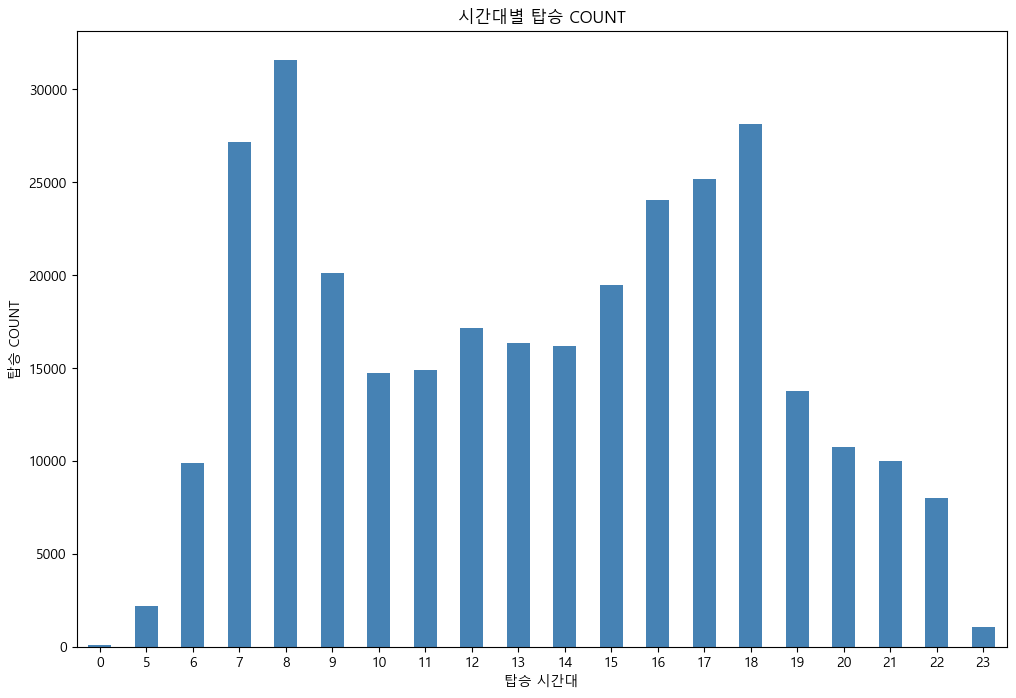

In [97]:
# GETON_HOUR을 기준으로 그룹화하여 해당 시간대별 이용자 수를 계산
hourly_usage = df_0413.groupby('GETON_HOUR')['CARD_NO'].count()

plt.figure(figsize=(12, 8))
hourly_usage.plot(kind='bar',  color = 'steelblue')
plt.xlabel('탑승 시간대')
plt.ylabel('탑승 COUNT')
plt.xticks(rotation=0)
plt.title('시간대별 탑승 COUNT')
plt.show()

## 출근 시간대 (7시, 8시, 9시)

In [98]:
from preprocessing import transf_data_preprocessing

df_0413_go_to = transf_data_preprocessing.filtering_time(df_0413, 7, 8, 9)
df_0413_go_to.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
18622,645141267,675,0,30300145,1,8002070,8001590,1,1250,0,2022-04-13 08:47:45,2022-04-13 09:21:45,8
18623,719499979,676,0,30300040,1,8001096,8002905,1,1250,0,2022-04-13 09:29:57,2022-04-13 09:34:45,9
18625,730468817,675,0,30300080,1,8001418,8001098,1,1250,0,2022-04-13 09:15:59,2022-04-13 09:40:56,9


### 환승횟수 2회

In [99]:
transf_is_2_morning, transf_is_not_2_morning = transf_data_preprocessing.transf_2_preprocessing(df_0413_go_to)
transf_is_2_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2817,90027797,676,0,30300131,1,8001079,8002814,1,1250,0,2022-04-13 07:06:57,2022-04-13 07:30:14,7
2818,90027797,676,1,30300054,1,8002814,8002556,1,0,0,2022-04-13 07:34:04,2022-04-13 07:39:22,7
2819,90027797,676,2,30300089,1,8001923,8002537,1,0,0,2022-04-13 07:48:21,2022-04-13 08:03:38,7


In [100]:
transf_is_2_morning_merge = transf_data_preprocessing.transf_2_merge(transf_is_2_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_2_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,90027797,676,203,0,8001079,1250,2022-04-13 07:06:57,36.306860,127.340850,8002814,0,2022-04-13 07:30:14,36.35306,127.379524,676,301,8002814,0,2022-04-13 07:34:04,36.35306,127.379524,8002556,0,2022-04-13 07:39:22,36.361683,127.379610,676,705,8001923,0,2022-04-13 07:48:21,8002537,0,2022-04-13 08:03:38,36.40083,127.40498
1,905335359,675,316,0,8001237,1250,2022-04-13 08:03:53,36.331840,127.385284,8002453,0,2022-04-13 08:16:23,36.35060,127.378130,675,318,8002453,0,2022-04-13 08:17:37,36.35060,127.378130,8002814,0,2022-04-13 08:18:05,36.353060,127.379524,676,705,8002814,0,2022-04-13 08:25:29,8002537,0,2022-04-13 08:49:24,36.40083,127.40498
2,166231305,675,315,0,8001849,1250,2022-04-13 07:41:15,36.306236,127.391830,8002814,0,2022-04-13 08:13:04,36.35306,127.379524,676,301,8002814,0,2022-04-13 08:14:04,36.35306,127.379524,8001923,0,2022-04-13 08:19:22,36.368570,127.379710,675,918,8001923,0,2022-04-13 08:22:30,8001326,0,2022-04-13 08:33:13,36.38845,127.37959


In [101]:
# 'GETOFF_BUS_STTN_ID_3' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = transf_is_2_morning_merge['GETOFF_BUS_STTN_ID_3'].value_counts().head(5).index

# DataFrame을 'GETOFF_BUS_STTN_ID_3' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_2_morning_merge[transf_is_2_morning_merge['GETOFF_BUS_STTN_ID_3'].isin(top_5_bus_sttn_ids)]

### 환승횟수 1회

In [104]:
transf_is_1_morning, transf_is_not_1_morning = transf_data_preprocessing.transf_1_preprocessing(df_0413_go_to)
transf_is_1_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
4925,90052852,676,0,30300073,1,8001997,8002235,1,1250,0,2022-04-13 07:48:10,2022-04-13 08:22:40,7
4926,90052852,676,1,30300037,1,8002235,8005960,1,0,0,2022-04-13 08:25:28,2022-04-13 08:30:02,8
5298,90053324,676,0,30300090,1,8005990,8002720,1,1250,0,2022-04-13 08:18:43,2022-04-13 08:29:28,8


In [105]:
transf_is_1_morning_merge = transf_data_preprocessing.transf_1_merge(transf_is_1_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_1_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,90052852,676,606,0,8001997,1250,2022-04-13 07:48:10,36.38632,127.345980,8002235,0,2022-04-13 08:22:40,36.357296,127.407845,676,102,8002235,0,2022-04-13 08:25:28,36.357296,127.407845,8005960,0,2022-04-13 08:30:02,36.358627,127.423065
1,515674272,675,617,0,8001952,1250,2022-04-13 09:22:00,36.34670,127.369545,8002235,0,2022-04-13 09:44:56,36.357296,127.407845,676,706,8002235,0,2022-04-13 09:50:09,36.357296,127.407845,8005960,0,2022-04-13 09:54:08,36.358627,127.423065
2,785010536,675,614,0,8007277,1250,2022-04-13 08:09:06,36.35176,127.411750,8002235,0,2022-04-13 08:13:36,36.357296,127.407845,676,102,8003006,0,2022-04-13 08:15:37,36.358120,127.412500,8005960,0,2022-04-13 08:19:31,36.358627,127.423065


In [106]:
# 'GETOFF_BUS_STTN_ID_2' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_1_morning_merge['GETOFF_BUS_STTN_ID_2'].value_counts().head(10).index

# DataFrame을 'GETOFF_BUS_STTN_ID_2' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_1_morning_merge[transf_is_1_morning_merge['GETOFF_BUS_STTN_ID_2'].isin(top_10_bus_sttn_ids)]

### 환승횟수 0회

In [111]:
transf_is_0_morning, transf_is_not_0_morning = transf_data_preprocessing.transf_0_preprocessing(df_0413_go_to)
transf_is_0_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
18623,719499979,676,0,30300040,1,8001096,8002905,1,1250,0,2022-04-13 09:29:57,2022-04-13 09:34:45,9
18625,730468817,675,0,30300080,1,8001418,8001098,1,1250,0,2022-04-13 09:15:59,2022-04-13 09:40:56,9
18870,531596480,675,0,30300049,1,8005928,8001204,1,1250,0,2022-04-13 08:28:09,2022-04-13 08:44:25,8


In [112]:
transf_is_0_morning_merge = transf_data_preprocessing.transf_0_merge(transf_is_0_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_0_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,719499979,676,105,0,8001096,1250,2022-04-13 09:29:57,36.349014,127.43566,8002905,0,2022-04-13 09:34:45,36.351494,127.42254
1,773763544,676,105,0,8001096,1250,2022-04-13 09:40:55,36.349014,127.43566,8002905,0,2022-04-13 09:46:15,36.351494,127.42254
2,793939124,676,105,0,8001096,1250,2022-04-13 08:47:29,36.349014,127.43566,8002905,0,2022-04-13 08:52:55,36.351494,127.42254


In [113]:
# 'GETOFF_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 20개의 값
top_20_bus_sttn_ids = transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].value_counts().head(20).index

# DataFrame을 'GETOFF_BUS_STTN_ID' 열의 값이 상위 20개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_0_morning_merge[transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].isin(top_20_bus_sttn_ids)]

In [115]:
transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].value_counts().head(10)

GETOFF_BUS_STTN_ID
8002453    872
8002412    476
8001097    438
8001927    420
8002814    413
8002969    373
8002921    365
8001934    363
8001420    352
8001412    339
Name: count, dtype: int64

## 퇴근 시간대 (16시, 17시, 18시)

In [116]:
from preprocessing import transf_data_preprocessing

df_0413_leave_to = transf_data_preprocessing.filtering_time(df_0413, 16, 17, 18)
df_0413_leave_to.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
18626,905509266,675,0,30300058,1,8001419,8001654,1,1250,0,2022-04-13 17:35:07,2022-04-13 17:59:28,17
18857,515758459,675,1,30300062,1,8001567,8001923,1,0,0,2022-04-13 17:45:41,2022-04-13 17:50:08,17
18858,666051394,675,0,30300058,1,8001419,8002916,1,1250,0,2022-04-13 16:50:30,2022-04-13 17:17:09,16


### 환승횟수 2회

In [117]:
transf_is_2_night, transf_is_not_2_night = transf_data_preprocessing.transf_2_preprocessing(df_0413_leave_to)
transf_is_2_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
884,93685350,675,0,30300082,1,8005998,8001934,1,1250,0,2022-04-13 17:14:55,2022-04-13 17:30:43,17
885,93685350,675,1,30300077,1,8001935,8001493,1,0,0,2022-04-13 17:37:42,2022-04-13 17:45:00,17
886,93685350,680,2,30300008,1,8001493,8001026,1,0,0,2022-04-13 17:52:22,2022-04-13 18:02:45,17


In [118]:
transf_is_2_night_merge = transf_data_preprocessing.transf_2_merge(transf_is_2_night, getrouteinfoall_df, bus_sttn_df)
transf_is_2_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,93685350,675,618,0,8005998,1250,2022-04-13 17:14:55,36.317390,127.425180,8001934,0,2022-04-13 17:30:43,36.320564,127.406425,675,613,8001935,0,2022-04-13 17:37:42,36.321037,127.40690,8001493,0,2022-04-13 17:45:00,36.314804,127.383514,680,23,8001493,0,2022-04-13 17:52:22,8001026,0,2022-04-13 18:02:45,36.298600,127.35589
1,759699652,676,603,0,8003101,1250,2022-04-13 17:41:15,36.332047,127.339424,8001240,0,2022-04-13 18:08:28,36.334217,127.387710,675,211,8001240,0,2022-04-13 18:17:50,36.334217,127.38771,8002545,0,2022-04-13 18:35:12,36.310250,127.372380,680,25,8002545,0,2022-04-13 18:43:23,8001026,0,2022-04-13 18:49:03,36.298600,127.35589
2,523144501,675,618,0,8002229,1250,2022-04-13 17:18:02,36.329080,127.404080,8001929,0,2022-04-13 17:22:40,36.322006,127.410500,675,119,8001929,0,2022-04-13 17:23:53,36.322006,127.41050,8001493,0,2022-04-13 17:32:22,36.314804,127.383514,680,22,8001493,0,2022-04-13 17:52:23,8002513,0,2022-04-13 18:24:14,36.214138,127.33683


In [119]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = transf_is_2_night_merge['GETON_BUS_STTN_ID_1'].value_counts().head(5).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_2_night_merge[transf_is_2_night_merge['GETON_BUS_STTN_ID_1'].isin(top_5_bus_sttn_ids)]

### 환승횟수 1회

In [125]:
transf_is_1_night, transf_is_not_1_night = transf_data_preprocessing.transf_1_preprocessing(df_0413_leave_to)
transf_is_1_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
9530,90026970,681,0,30300042,1,8002409,8001054,1,1250,0,2022-04-13 16:10:42,2022-04-13 16:21:35,16
9531,90026970,675,1,30300056,1,8001053,8001902,1,0,0,2022-04-13 16:26:50,2022-04-13 16:29:41,16
16801,90069354,676,0,30300041,1,8002703,8001077,1,1250,0,2022-04-13 17:56:08,2022-04-13 18:10:12,17


In [126]:
transf_is_1_night_merge = transf_data_preprocessing.transf_1_merge(transf_is_1_night, getrouteinfoall_df, bus_sttn_df)
transf_is_1_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,90026970,681,107,0,8002409,1250,2022-04-13 16:10:42,36.354187,127.33980,8001054,0,2022-04-13 16:21:35,36.353497,127.36766,675,312,8001053,0,2022-04-13 16:26:50,36.353092,127.36841,8001902,0,2022-04-13 16:29:41,36.34579,127.36829
1,755719888,681,107,0,8002279,1250,2022-04-13 18:05:48,36.339160,127.39248,8001056,0,2022-04-13 18:22:24,36.353638,127.36852,675,119,8001053,0,2022-04-13 18:24:48,36.353092,127.36841,8001902,0,2022-04-13 18:28:16,36.34579,127.36829
2,645337185,676,105,0,8005865,1250,2022-04-13 17:32:46,36.346850,127.38567,8001056,0,2022-04-13 17:43:13,36.353638,127.36852,675,312,8001053,0,2022-04-13 17:51:09,36.353092,127.36841,8001902,0,2022-04-13 17:53:48,36.34579,127.36829


In [127]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_1_night_merge['GETON_BUS_STTN_ID_1'].value_counts().head(10).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_1_night_merge[transf_is_1_night_merge['GETON_BUS_STTN_ID_1'].isin(top_10_bus_sttn_ids)]

### 환승횟수 0회

In [130]:
transf_is_0_night, transf_is_not_0_night = transf_data_preprocessing.transf_0_preprocessing(df_0413_leave_to)
transf_is_0_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
18626,905509266,675,0,30300058,1,8001419,8001654,1,1250,0,2022-04-13 17:35:07,2022-04-13 17:59:28,17
18858,666051394,675,0,30300058,1,8001419,8002916,1,1250,0,2022-04-13 16:50:30,2022-04-13 17:17:09,16
18866,778504978,675,0,30300055,1,8001349,8002340,1,1250,0,2022-04-13 16:24:01,2022-04-13 16:25:38,16


In [131]:
transf_is_0_night_merge = transf_data_preprocessing.transf_0_merge(transf_is_0_night, getrouteinfoall_df, bus_sttn_df)
transf_is_0_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,905509266,675,314,0,8001419,1250,2022-04-13 17:35:07,36.332737,127.431725,8001654,0,2022-04-13 17:59:28,36.310802,127.39131
1,773097386,675,314,2,8001929,0,2022-04-13 16:25:58,36.322006,127.410500,8001654,0,2022-04-13 16:37:22,36.310802,127.39131
2,714450274,675,314,0,8001935,1250,2022-04-13 16:27:05,36.321037,127.406900,8001654,0,2022-04-13 16:36:07,36.310802,127.39131


In [132]:
# 'GETON_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 20개의 값
top_20_bus_sttn_ids = transf_is_0_night_merge['GETON_BUS_STTN_ID'].value_counts().head(20).index

# DataFrame을 'GETON_BUS_STTN_ID' 열의 값이 상위 20개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_0_night_merge[transf_is_0_night_merge['GETON_BUS_STTN_ID'].isin(top_20_bus_sttn_ids)]

# 4월 19일 데이터

In [135]:
df_0419 = smart_card_data[smart_card_data['DAY']==19]
df_0419.drop(labels = ['WEEKDAY','DAY'],axis = 1, inplace = True)
df_0419['GETON_HOUR'] = df_0419['GETON_DATETIME'].dt.hour
df_0419.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2595433,509081686,676,0,30300089,1,8002207,8002468,1,1250,0,2022-04-19 20:49:50,2022-04-19 21:10:40,20
2595434,316672093,676,0,30300070,1,8002296,8002357,1,1250,0,2022-04-19 10:49:49,2022-04-19 11:02:16,10
2595435,266315113,676,0,30300040,1,8002412,8005516,1,1250,0,2022-04-19 08:08:55,2022-04-19 08:12:34,8


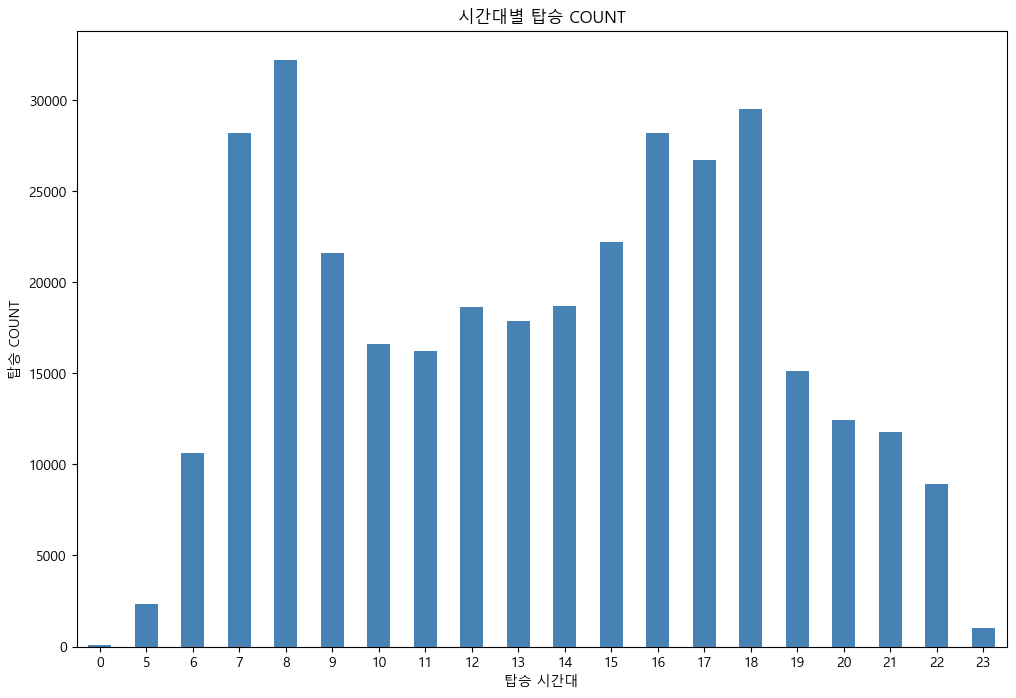

In [136]:
# GETON_HOUR을 기준으로 그룹화하여 해당 시간대별 이용자 수를 계산
hourly_usage = df_0419.groupby('GETON_HOUR')['CARD_NO'].count()

plt.figure(figsize=(12, 8))
hourly_usage.plot(kind='bar',  color = 'steelblue')
plt.xlabel('탑승 시간대')
plt.ylabel('탑승 COUNT')
plt.xticks(rotation=0)
plt.title('시간대별 탑승 COUNT')
plt.show()

## 출근 시간대 (7시, 8시, 9시)

In [137]:
from preprocessing import transf_data_preprocessing

df_0419_go_to = transf_data_preprocessing.filtering_time(df_0419, 7, 8, 9)
df_0419_go_to.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2595435,266315113,676,0,30300040,1,8002412,8005516,1,1250,0,2022-04-19 08:08:55,2022-04-19 08:12:34,8
2595441,266311853,676,0,30300037,1,8002236,9002077,1,1250,0,2022-04-19 09:40:24,2022-04-19 10:21:06,9
2595443,536245654,676,0,30300039,1,8001077,8001923,1,1250,0,2022-04-19 09:47:08,2022-04-19 09:58:59,9


### 환승횟수 2회

In [138]:
transf_is_2_morning, transf_is_not_2_morning = transf_data_preprocessing.transf_2_preprocessing(df_0419_go_to)
transf_is_2_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2794,90027797,676,0,30300131,1,8001079,8002814,1,1250,0,2022-04-19 07:08:40,2022-04-19 07:33:59,7
2795,90027797,676,1,30300054,1,8002814,8001923,1,0,0,2022-04-19 07:35:18,2022-04-19 07:40:55,7
2796,90027797,675,2,30300096,1,8001923,8002026,1,0,0,2022-04-19 08:02:29,2022-04-19 08:18:56,8


In [139]:
transf_is_2_morning_merge = transf_data_preprocessing.transf_2_merge(transf_is_2_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_2_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,90027797,676,203,0,8001079,1250,2022-04-19 07:08:40,36.30686,127.340850,8002814,0,2022-04-19 07:33:59,36.353060,127.379524,676,301,8002814,0,2022-04-19 07:35:18,36.353060,127.379524,8001923,0,2022-04-19 07:40:55,36.36857,127.37971,675,918,8001923,0,2022-04-19 08:02:29,8002026,0,2022-04-19 08:18:56,36.399710,127.40374
1,776120446,676,203,0,8007011,1250,2022-04-19 09:31:46,36.34420,127.375030,8002814,0,2022-04-19 09:37:36,36.353060,127.379524,676,705,8002814,0,2022-04-19 09:42:26,36.353060,127.379524,8001923,0,2022-04-19 09:48:40,36.36857,127.37971,676,604,8001923,0,2022-04-19 09:51:16,8001742,0,2022-04-19 09:55:21,36.372185,127.37444
2,510441739,676,102,0,8002658,1250,2022-04-19 08:15:50,36.35911,127.424904,8002075,0,2022-04-19 08:25:25,36.357666,127.397480,675,911,8002076,0,2022-04-19 08:31:57,36.358475,127.395380,8001923,0,2022-04-19 08:40:47,36.36857,127.37971,676,104,8001923,0,2022-04-19 08:48:12,8001742,0,2022-04-19 08:54:01,36.372185,127.37444


In [140]:
# 'GETOFF_BUS_STTN_ID_3' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = transf_is_2_morning_merge['GETOFF_BUS_STTN_ID_3'].value_counts().head(5).index

# DataFrame을 'GETOFF_BUS_STTN_ID_3' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_2_morning_merge[transf_is_2_morning_merge['GETOFF_BUS_STTN_ID_3'].isin(top_5_bus_sttn_ids)]

### 환승횟수 1회

In [143]:
transf_is_1_morning, transf_is_not_1_morning = transf_data_preprocessing.transf_1_preprocessing(df_0419_go_to)
transf_is_1_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
5465,90053324,676,0,30300041,1,8005990,8002720,1,1250,0,2022-04-19 08:09:23,2022-04-19 08:22:04,8
5466,90053324,677,1,30300129,1,8002722,8007339,1,0,0,2022-04-19 08:37:05,2022-04-19 08:52:28,8
18416,90069322,675,0,30300078,1,8007278,8001528,1,1250,0,2022-04-19 09:10:11,2022-04-19 09:19:32,9


In [144]:
transf_is_1_morning_merge = transf_data_preprocessing.transf_1_merge(transf_is_1_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_1_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,90053324,676,106,0,8005990,1250,2022-04-19 08:09:23,36.34622,127.340460,8002720,0,2022-04-19 08:22:04,36.361355,127.34468,677,1002,8002722,0,2022-04-19 08:37:05,36.36265,127.34368,8007339,0,2022-04-19 08:52:28,36.37421,127.30568
1,793874108,673,5,0,8003041,1100,2022-04-19 08:08:58,36.39692,127.373470,8001193,0,2022-04-19 08:24:41,36.360800,127.34954,677,1002,8001193,150,2022-04-19 08:32:51,36.36080,127.34954,8007339,0,2022-04-19 08:48:07,36.37421,127.30568
2,657731195,676,106,0,8070030,1250,2022-04-19 08:22:06,36.33381,127.338264,8002720,0,2022-04-19 08:45:24,36.361355,127.34468,677,1002,8002722,0,2022-04-19 08:55:09,36.36265,127.34368,8007345,300,2022-04-19 09:38:35,36.47813,127.28786


In [145]:
# 'GETOFF_BUS_STTN_ID_2' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_1_morning_merge['GETOFF_BUS_STTN_ID_2'].value_counts().head(10).index

# DataFrame을 'GETOFF_BUS_STTN_ID_2' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_1_morning_merge[transf_is_1_morning_merge['GETOFF_BUS_STTN_ID_2'].isin(top_10_bus_sttn_ids)]

### 환승횟수 0회

In [150]:
transf_is_0_morning, transf_is_not_0_morning = transf_data_preprocessing.transf_0_preprocessing(df_0419_go_to)
transf_is_0_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2595435,266315113,676,0,30300040,1,8002412,8005516,1,1250,0,2022-04-19 08:08:55,2022-04-19 08:12:34,8
2595441,266311853,676,0,30300037,1,8002236,9002077,1,1250,0,2022-04-19 09:40:24,2022-04-19 10:21:06,9
2595449,102455056,676,0,30300036,1,8001994,8002280,1,1250,0,2022-04-19 07:12:08,2022-04-19 07:30:34,7


In [151]:
transf_is_0_morning_merge = transf_data_preprocessing.transf_0_merge(transf_is_0_morning, getrouteinfoall_df, bus_sttn_df)
transf_is_0_morning_merge.head(3)

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,266315113,676,105,0,8002412,1250,2022-04-19 08:08:55,36.354378,127.342026,8005516,0,2022-04-19 08:12:34,36.36037,127.34432
1,908398432,676,105,2,8002412,0,2022-04-19 09:06:12,36.354378,127.342026,8005516,0,2022-04-19 09:09:31,36.36037,127.34432
2,750860440,676,105,2,8002412,0,2022-04-19 08:35:38,36.354378,127.342026,8005516,0,2022-04-19 08:39:21,36.36037,127.34432


In [152]:
# 'GETOFF_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 20개의 값
top_20_bus_sttn_ids = transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].value_counts().head(20).index

# DataFrame을 'GETOFF_BUS_STTN_ID' 열의 값이 상위 20개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_0_morning_merge[transf_is_0_morning_merge['GETOFF_BUS_STTN_ID'].isin(top_20_bus_sttn_ids)]

## 퇴근 시간대 (16시, 17시, 18시)

In [155]:
from preprocessing import transf_data_preprocessing

df_0419_leave_to = transf_data_preprocessing.filtering_time(df_0419, 16, 17, 18)
df_0419_leave_to.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2595439,541351851,675,0,30300057,1,8001280,8002803,1,1250,0,2022-04-19 16:11:56,2022-04-19 16:32:34,16
2595440,171919965,675,0,30300079,1,8007446,8001854,1,1250,0,2022-04-19 18:27:27,2022-04-19 18:44:27,18
2595445,303146549,676,0,30300069,1,8001587,8002650,1,1250,0,2022-04-19 16:19:05,2022-04-19 16:27:00,16


### 환승횟수 2회

In [156]:
transf_is_2_night, transf_is_not_2_night = transf_data_preprocessing.transf_2_preprocessing(df_0419_leave_to)
transf_is_2_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
948,90424948,675,0,30300057,1,8001850,8001847,1,1250,0,2022-04-19 16:39:00,2022-04-19 16:43:55,16
949,90424948,675,1,30300047,1,8001846,8002119,1,0,0,2022-04-19 16:55:35,2022-04-19 17:04:16,16
950,90424948,680,2,30300021,1,8002119,8001916,1,0,0,2022-04-19 17:09:31,2022-04-19 17:26:50,17


In [157]:
transf_is_2_night_merge = transf_data_preprocessing.transf_2_merge(transf_is_2_night, getrouteinfoall_df, bus_sttn_df)
transf_is_2_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,90424948,675,313,0,8001850,1250,2022-04-19 16:39:00,36.306515,127.392075,8001847,0,2022-04-19 16:43:55,36.303757,127.386055,675,115,8001846,0,2022-04-19 16:55:35,36.303290,127.386314,8002119,0,2022-04-19 17:04:16,36.311700,127.376640,680,46,8002119,0,2022-04-19 17:09:31,8001916,0,2022-04-19 17:26:50,36.299870,127.32176
1,771909394,683,32,0,8001481,1250,2022-04-19 17:27:55,36.232903,127.407745,8001852,0,2022-04-19 17:51:47,36.306076,127.386860,675,115,8001852,0,2022-04-19 18:10:41,36.306076,127.386860,8002119,0,2022-04-19 18:18:33,36.311700,127.376640,674,1,8002119,0,2022-04-19 18:19:01,8001584,0,2022-04-19 18:31:11,36.300438,127.32627
2,725275082,676,704,0,8001196,1250,2022-04-19 18:17:35,36.366250,127.338710,8002721,0,2022-04-19 18:24:57,36.361560,127.344110,676,101,8002721,0,2022-04-19 18:26:11,36.361560,127.344110,8001596,0,2022-04-19 18:32:09,36.351994,127.346794,674,3,8070015,0,2022-04-19 18:44:13,8001584,0,2022-04-19 19:06:53,36.300438,127.32627


In [158]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = transf_is_2_night_merge['GETON_BUS_STTN_ID_1'].value_counts().head(5).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_2_night_merge[transf_is_2_night_merge['GETON_BUS_STTN_ID_1'].isin(top_5_bus_sttn_ids)]

### 환승횟수 1회

In [161]:
transf_is_1_night, transf_is_not_1_night = transf_data_preprocessing.transf_1_preprocessing(df_0419_leave_to)
transf_is_1_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
5066,87595336,832,0,30300128,1,8007290,8001420,1,1700,0,2022-04-19 17:19:54,2022-04-19 17:44:35,17
5067,87595336,676,1,30300093,1,8001647,8001995,1,0,0,2022-04-19 18:07:02,2022-04-19 18:14:33,18
5000,90052852,676,0,30300037,1,8002658,8002075,1,1250,0,2022-04-19 16:26:44,2022-04-19 16:36:25,16


In [162]:
transf_is_1_night_merge = transf_data_preprocessing.transf_1_merge(transf_is_1_night, getrouteinfoall_df, bus_sttn_df)
transf_is_1_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,87595336,832,B1,0,8007290,1700,2022-04-19 17:19:54,36.438030,127.39567,8001420,0,2022-04-19 17:44:35,36.333435,127.431410,676,802,8001647,0,2022-04-19 18:07:02,36.329340,127.42811,8001995,0,2022-04-19 18:14:33,36.341225,127.43724
1,545308060,675,512,0,8001467,1250,2022-04-19 16:05:23,36.298443,127.45881,8003054,0,2022-04-19 16:31:33,36.330112,127.433365,676,605,8001412,0,2022-04-19 16:47:37,36.329525,127.43368,8001995,0,2022-04-19 16:56:11,36.341225,127.43724
2,742868381,675,514,0,8005874,1250,2022-04-19 18:13:22,36.305830,127.45812,8001412,0,2022-04-19 18:31:55,36.329525,127.433680,676,605,8001412,0,2022-04-19 18:33:08,36.329525,127.43368,8001995,0,2022-04-19 18:39:50,36.341225,127.43724


In [164]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_1_night_merge['GETON_BUS_STTN_ID_1'].value_counts().head(10).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_1_night_merge[transf_is_1_night_merge['GETON_BUS_STTN_ID_1'].isin(top_10_bus_sttn_ids)]

### 환승횟수 0회

In [166]:
transf_is_0_night, transf_is_not_0_night = transf_data_preprocessing.transf_0_preprocessing(df_0419_leave_to)
transf_is_0_night.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
2595439,541351851,675,0,30300057,1,8001280,8002803,1,1250,0,2022-04-19 16:11:56,2022-04-19 16:32:34,16
2595440,171919965,675,0,30300079,1,8007446,8001854,1,1250,0,2022-04-19 18:27:27,2022-04-19 18:44:27,18
2595445,303146549,676,0,30300069,1,8001587,8002650,1,1250,0,2022-04-19 16:19:05,2022-04-19 16:27:00,16


In [167]:
transf_is_0_night_merge = transf_data_preprocessing.transf_0_merge(transf_is_0_night, getrouteinfoall_df, bus_sttn_df)
transf_is_0_night_merge.head(3)

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,541351851,675,313,0,8001280,1250,2022-04-19 16:11:56,36.288470,127.380196,8002803,0,2022-04-19 16:32:34,36.318108,127.419106
1,171824476,675,313,0,8002328,1250,2022-04-19 17:38:44,36.293278,127.383125,8002803,0,2022-04-19 17:54:32,36.318108,127.419106
2,303136154,675,313,0,8002937,1250,2022-04-19 16:01:51,36.283140,127.376090,8002803,0,2022-04-19 16:33:51,36.318108,127.419106


In [168]:
# 'GETON_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = transf_is_0_night_merge['GETON_BUS_STTN_ID'].value_counts().head(10).index

# DataFrame을 'GETON_BUS_STTN_ID' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = transf_is_0_night_merge[transf_is_0_night_merge['GETON_BUS_STTN_ID'].isin(top_10_bus_sttn_ids)]

In [169]:
transf_is_0_night_merge['GETON_BUS_STTN_ID'].value_counts().head(10).index


Index([8002920, 8001922, 8001096, 8001418, 8001078, 8002721, 8001097, 8001412,
       8001641, 8002831],
      dtype='int64', name='GETON_BUS_STTN_ID')

In [170]:
transf_is_0_night_merge['GETON_BUS_STTN_ID'].value_counts().head(10)


GETON_BUS_STTN_ID
8002920    531
8001922    401
8001096    393
8001418    351
8001078    338
8002721    303
8001097    275
8001412    274
8001641    252
8002831    236
Name: count, dtype: int64